# Лабораторная работа 4

## Практика TensorFlow 2.x

### Задание

В данной лабораторной работе будет практиковаться материал из лекций по TensorFlow на примере решения задачи классификации изображений из датасета Fashion MNIST. Fashion MNIST - набор черно-белых изображений размера 28х28, что поделены на 10 классов. Будет построена с нуля и обучена модель логистической регрессии используя как низкоуровневый API. Опционально решение той же задачи нейронной сетью, построенной и обученной с использованием Keras.

0 Базовые операции. 
   - 0.1 Сгенерируйте три непересекающихся гауссовых облака, используя `tf.random`. Визуализируйте их разными цветами, используя matplotlib. 
   - 0.2 Сгенерируйте случайную матрицу 2x2, умножьте каждую точку в облаках на эту матрицу. Повторно визуализируйте облака.

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

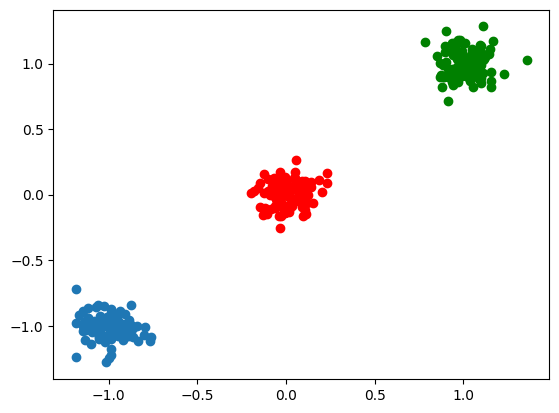

In [9]:
cloud1 = tf.random.normal([100, 2], mean=-1, stddev=0.1)

plt.scatter(cloud1[:, 0], cloud1[:, 1])

cloud2 = tf.random.normal([100, 2], mean=1, stddev=0.1)

plt.scatter(cloud2[:, 0], cloud2[:, 1], c='green')

cloud3 = tf.random.normal([100, 2], mean=0, stddev=0.1)

plt.scatter(cloud3[:, 0], cloud3[:, 1], c='red')


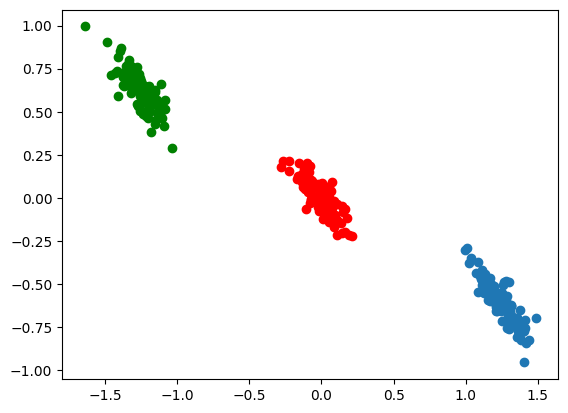

In [10]:
matrix = tf.random.normal([2, 2])

cloud1 = cloud1 @ matrix
cloud2 = cloud2 @ matrix
cloud3 = cloud3 @ matrix

plt.scatter(cloud1[:, 0], cloud1[:, 1])
plt.scatter(cloud2[:, 0], cloud2[:, 1], c='green')
plt.scatter(cloud3[:, 0], cloud3[:, 1], c='red')

1 Загрузите датасет Fashion MNIST, используя метод из [tf.keras.datasets](https://www.tensorflow.org/api_docs/python/tf/keras/datasets). Визуализируйте несколько изображений, используя библиотеку matplotlib.

In [11]:
mnist = tf.keras.datasets.fashion_mnist.load_data()

4422102/4422102 [==============================] - 1s 0us/step


In [12]:
(x_train, y_train), (x_test, y_test) = mnist

2 Нормализуйте данные либо средним и СКО, либо приведя значения пикселей в интервал [-1, 1].

In [13]:
mean_image = x_train.mean(axis=0)
stds = x_train.std(axis=0) + 1e-15

In [14]:
def normalize(tensor):
    return (tensor - mean_image) / stds

In [15]:
x_train = normalize(x_train)
x_test = normalize(x_test)

3 Создайте обучающий и тестовый TensorFlow Dataset из нормализованного набора данных. К обучающему датасету добавьте перемешивание (`.shuffle`). К обоим датасетам добавьте генерацию батчей размера 128 (`.batch(128)`).

In [16]:
from tensorflow.data import Dataset

In [17]:
train_dataset = Dataset.from_tensor_slices((x_train, y_train)).shuffle(60000).batch(128)
test_dataset = Dataset.from_tensor_slices((x_test, y_test)).batch(128)

4 Напишите класс слоя `Flatten`, что трансформирует изображения из матричного в векторный вид: [28, 28] -> [28 * 28]. Класс слоя должен наследоваться от `tf.Module`. Для трансформации тензоров изображений использовать `tf.reshape`.

In [20]:
class Flatten(tf.Module):
    def __init__(self):
        super().__init__()
    
    def __call__(self, x):
        shape = x.shape
        reshape = tf.reshape(x, [shape[0], shape[1] * shape[2]])
        return reshape


5 Напишите класс линейного слоя `Linear`, что умножает входной вектор на матрицу весов. Класс слоя должен наследоваться от `tf.Module`. Матрицу весов хранить в `tf.Variable`. Параметры конструктора: `in_d` - размерность входного вектора, `out_d` - размерность выходного вектора. В качестве начальной инициализации весов использовать гауссово распределение с СКО=0.01.

In [22]:
class Linear(tf.Module):
    def __init__(self, in_d, out_d):
        super().__init__()
        self.w = tf.Variable(tf.random.normal([in_d, out_d], stddev=0.01, dtype=tf.dtypes.float64))
        self.b = tf.Variable(tf.zeros(out_d, dtype=tf.dtypes.float64))
    
    def __call__(self, x):
        return tf.matmul(x, self.w) + self.b
        

6 Напишите класс модели логистической регрессии `LogisticRegression`, что компонует в себе слои `Linear` и `Flatten`. Класс модели должен наследоваться от `tf.Module`. В качестве функции активации используйте `tf.nn.softmax`.
Создайте объект модели и попробуйте с помощью неё классифицировать одно изображение (не забудьте о размерности батча! Она будет равна 1).

In [23]:
class LogisticRegression(tf.Module):
    def __init__(self):
        super().__init__()
        self.flatten = Flatten()
        self.linear = Linear(28*28, 10)
    
    def __call__(self, x):
        
        return tf.nn.softmax(self.linear(self.flatten(x)))

In [26]:
model = LogisticRegression()
model(tf.convert_to_tensor(x_train[0:1]))

<tf.Tensor: shape=(1, 10), dtype=float64, numpy=
array([[0.10025999, 0.08429345, 0.12421889, 0.05330222, 0.07332701,
        0.16442082, 0.09577805, 0.11197406, 0.12304085, 0.06938468]])>

7 Напишите функцию оценки точности модели `evaluate`. Список её аргументов: тестовый tf.Dataset, модель. Данная функция будет отличаться оной из лекций тем, что внутри неё не будет ручной выборки батчей из датасета, поскольку tf.Dataset уже делает это за нас.

In [27]:
def evaluate(dataset, model):
    _sum = 0
    _batches = 0
    for batch in test_dataset:
        _batches += 1
        X, y = batch
        pred_y = model(X)
        pred_y_max = tf.argmax(pred_y, axis=1)
        _sum += (pred_y_max == y.numpy()).numpy().mean()
    return _sum / _batches

8 Напишите функцию обучающего шага `train_step`. Данная функция будет немного отличаться от показанной в лекции тем, что ей на вход также дается функция ошибки. Полный список аргументов: модель, тупл данных (батч картинок, батч меток), оптимизатор, функция ошибки. Функция `train_step` должна возвращать вычисленное значение функции ошибки.

В данной лабораторной функция ошибки не будет писаться заново, будет использоваться готовая кросс-энтропия из Keras.

In [28]:
def train_step(model, data, optimizer, loss_function):
    X, y = data
    with tf.GradientTape() as tape:
        predictions = model(X)
        loss = loss_function(y, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss


9 Оцените точность модели.

In [30]:
evaluate(test_dataset, model)

0.17978639240506328

10 Подготовьте гиперпараметры обучения: оптимизатор, функция ошибки ([tf.keras.losses.SparseCategoricalCrossentropy](https://www.tensorflow.org/api_docs/python/tf/keras/losses/SparseCategoricalCrossentropy)), количество эпох.

In [31]:
optimizer = tf.keras.optimizers.Adam()
loss_function = tf.keras.losses.SparseCategoricalCrossentropy()
epochs = 10

11 Напишите обучающий цикл. Цикл состоит из внешнего цикла, что отсчитывает эпохи, и вложенного, что итерируется по обучающему датасету.
Во вложенном цикле должна вызываться функция `train_step`. Каждую эпоху модель должна тестироваться функцией `evaluate`. Должны выводиться номер эпохи, значение ошибки и точности. Сохраняйте значения ошибки и точности в списки. Обучите модель. По ходу обучения подбирайте более оптимальные гиперпараметры обучения (learning_rate, другой оптимизатор).

In [32]:
losses = []
accs = []
for epoch in range(epochs):
    loss = 0
    for batch in train_dataset:
        loss += train_step(model, batch, optimizer, loss_function)
    acc =evaluate(test_dataset, model)
    print("epoch", epoch, "loss", loss, 'accuracy', acc)
    losses.append(loss)
    accs.append(acc)


epoch 0 loss tf.Tensor(251.50822655932387, shape=(), dtype=float64) accuracy 0.8314873417721519
epoch 1 loss tf.Tensor(204.72947888686267, shape=(), dtype=float64) accuracy 0.8365308544303798
epoch 2 loss tf.Tensor(196.57350859655162, shape=(), dtype=float64) accuracy 0.8391020569620253
epoch 3 loss tf.Tensor(192.53337860122238, shape=(), dtype=float64) accuracy 0.8407832278481012
epoch 4 loss tf.Tensor(189.00098552713172, shape=(), dtype=float64) accuracy 0.8415743670886076
epoch 5 loss tf.Tensor(186.49224535924873, shape=(), dtype=float64) accuracy 0.8367286392405063
epoch 6 loss tf.Tensor(185.36425751583812, shape=(), dtype=float64) accuracy 0.8417721518987342
epoch 7 loss tf.Tensor(184.0767365004449, shape=(), dtype=float64) accuracy 0.8361352848101266
epoch 8 loss tf.Tensor(182.09086225378778, shape=(), dtype=float64) accuracy 0.8388053797468354
epoch 9 loss tf.Tensor(181.35193072660186, shape=(), dtype=float64) accuracy 0.8399920886075949


12 Выведите графики точности и ошибки, используя matplotlib.

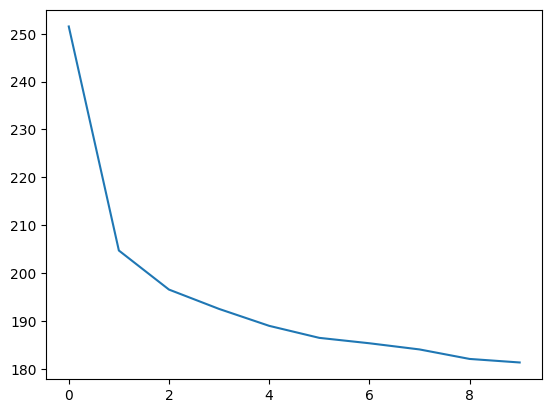

In [33]:
plt.plot(losses)

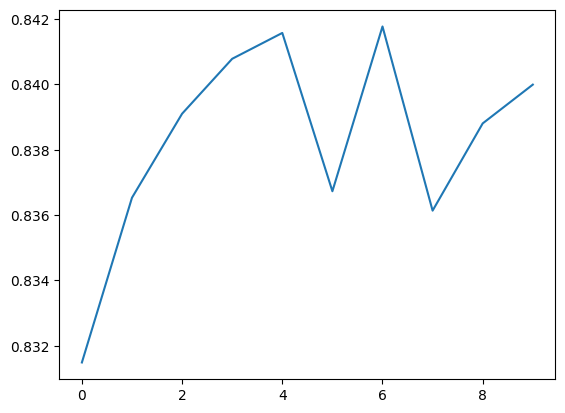

In [34]:
plt.plot(accs)

13 (Опционально) Постройте и обучите произвольную нейронную сеть с использованием Keras для решения той же задачи. 